### > Описание эксперимента
Перед вами таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.

#### Описание колонок
value – значения метрики

experimentVariant – Вариант теста (Control – контроль, Treatment – тест)
#### Задача
Нужно понять, стали ли мы больше зарабатывать с пользователя или нет. Вы уже знаете о существовании t-теста, U-теста Mann-Whitney и бутстрапа. Открытый вопрос: какой инструмент использовать?

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import scipy.stats as ss

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
hw_bootstrap=pd.read_csv('~/statistics/hw_bootstrap.csv', sep=';')

In [3]:
hw_bootstrap

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
...,...,...,...
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment


In [4]:
hw_bootstrap.dtypes  

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [5]:
hw_bootstrap.value=hw_bootstrap.value.apply(lambda x: str(x.replace(',','.')))

In [6]:
hw_bootstrap["value"]=hw_bootstrap.value.astype(float)

In [7]:
hw_bootstrap.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [8]:
hw_bootstrap

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment


In [9]:
hw_bootstrap.columns

Index(['Unnamed: 0', 'value', 'experimentVariant'], dtype='object')

In [10]:
hw_bootstrap=hw_bootstrap.rename(columns={"Unnamed: 0": "id"})

In [11]:
hw_bootstrap

,id,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment


In [12]:
hw_bootstrap.groupby('experimentVariant').agg({'value':'count'})

,value
experimentVariant,
Control,500
Treatment,500


In [13]:
#в выборке есть выбросы от них требуется избавится для более лутьшего анализа

In [14]:
hw_bootstrap.value.sort_values(ascending=False).head(10)

999    3000.000000
998    2000.000000
997    1500.000000
996    1200.000000
995    1000.000000
671      13.130346
171      13.130346
195      12.817541
695      12.817541
794      12.728285
Name: value, dtype: float64

In [15]:
hw_bootstrap=hw_bootstrap.query("id<=995")
hw_bootstrap

,id,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
990,991,10.916229,Treatment
991,992,11.160869,Treatment
992,993,8.202518,Treatment
993,994,9.782199,Treatment


In [16]:
hw_bootstrap.groupby('experimentVariant').agg({'value':'count'})

,value
experimentVariant,
Control,500
Treatment,495


In [17]:
hw_bootstrap.groupby('experimentVariant').agg({'value':'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,10.021716


In [18]:
hw_bootstrap.groupby('experimentVariant').agg({'value':'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.015492


In [19]:
ss.normaltest(hw_bootstrap.value)

NormaltestResult(statistic=5.831363785881354, pvalue=0.05416708228583246)

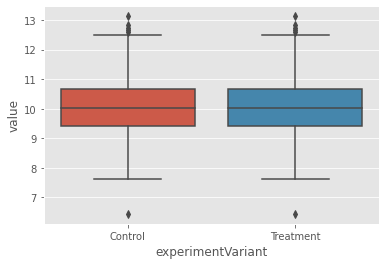

In [20]:
sns.boxplot(x="experimentVariant", y="value", data=hw_bootstrap)

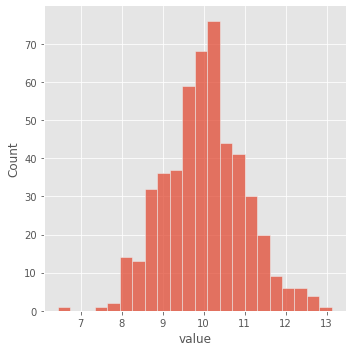

In [21]:
sns.displot(hw_bootstrap[hw_bootstrap.experimentVariant=='Control'].value, kde=False)

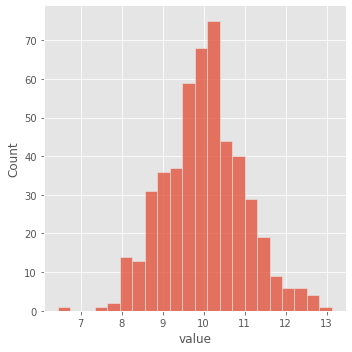

In [22]:
sns.displot(hw_bootstrap[hw_bootstrap.experimentVariant=='Treatment'].value, kde=False)

In [23]:
#1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

In [24]:
mannwhitneyu(hw_bootstrap[hw_bootstrap.experimentVariant=='Treatment'].value,
            hw_bootstrap[hw_bootstrap.experimentVariant=='Control'].value)

MannwhitneyuResult(statistic=123310.5, pvalue=0.9228386264147465)

In [25]:
ttest_ind(hw_bootstrap[hw_bootstrap.experimentVariant=='Treatment'].value,
            hw_bootstrap[hw_bootstrap.experimentVariant=='Control'].value)

Ttest_indResult(statistic=-0.08299135107595523, pvalue=0.9338751428058142)

In [26]:
#функция, которая позволит проверять гипотезы с помощью бутстрапа

In [27]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

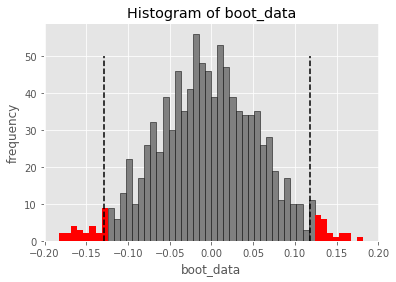

In [28]:
booted_data = get_bootstrap(hw_bootstrap[hw_bootstrap.experimentVariant=='Treatment'].value,\
              hw_bootstrap[hw_bootstrap.experimentVariant=='Control'].value)

In [29]:
booted_data["p_value"]#Альфа

0.9437308023823396

In [30]:
booted_data["quants"]#ДИ

,0
0.025,-0.128377
0.975,0.118408


In [34]:
#MannwhitneyuResult statistic=123310.5,          pvalue=0.9228386264147465
#Ttest_indResult statistic=-0.08299135107595523, pvalue=0.9338751428058142
#bootstrap                                       pvalue=0.9437308023823396


In [35]:

# Сдесь можно применить Т-тест т.к. у нас две группы (Control и Treatment) количественных признаков с нормальным распределением 


# U-критерий Манна-Уитни используется для сравнения различий между двумя независимыми выборками, когда распределение выборки не 
# является нормальным, а размеры выборки малы (n<30). Он считается непараметрическим эквивалентом двух выборочного независимого
# t-критерия. Данный метод сдесь не применим т.к. выборка большая и распределение выборки нормальное. что подтверждается тестом 
# на нормальность распределения NormaltestResult(statistic=5.831363785881354, pvalue=0.05416708228583246)

# Так же для более глубокого иследования можно использовать bootstrap

In [36]:
# У нас все 3 теста показали значения pvalue>0.05, а это значит что мы не можем отклонить 0 гипотезу и приходим к выводу,
# что нет достаточных доказательств того, что мы стали зарабатывать с пользователя больше 